In [12]:
import importlib

import Bio
import kMC_sequence_design_pytorch
import models
import numpy as np
import pandas as pd
import predict_pytorch
import pyBigWig as pbw
import torch
import train_pytorch
import utils
from Bio import SeqIO
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from torch import nn
from torch.utils.data import DataLoader, Dataset

fasta_file = "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa"
nuc_file = "/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.bw"
pol_file = (
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_pol_ratio.bw"
)
coh_file = (
    "/home/alex/shared_folder/SCerevisiae/data/GSE217022/labels_myco_coh_ratio.bw"
)

In [2]:
importlib.reload(predict_pytorch)
importlib.reload(train_pytorch)
importlib.reload(models)
importlib.reload(kMC_sequence_design_pytorch)

<module 'kMC_sequence_design_pytorch' from '/home/alex/SCerevisiae_chromatin_NN_prediction/kMC_sequence_design_pytorch.py'>

In [15]:
def write_bw(filename, signals, lengths=None, starts=None):
    if starts is None:
        starts = {k: 0 for k in signals.keys()}
    bw_lengths = {k: starts[k] + len(v) for k, v in signals.items()}
    if lengths is not None:
        for k, bw_len in bw_lengths.items():
            if bw_len > lengths[k]:
                print(
                    f"Specified length ({lengths[k]}) for chromosome {k} is too small "
                    f"for signal of length {len(signals[k])} and start at {starts[k]}. "
                    f"Changing to {bw_len}"
                )
                lengths[k] = bw_len
        bw_lengths = lengths
    bw = pbw.open(str(filename), "w")
    bw.addHeader([(k, v) for k, v in lengths.items()])
    for chr_id, val in signals.items():
        bw.addEntries(chr_id, starts[k], values=val, span=1, step=1)
    bw.close()


def nanpearson(a, b):
    """Compute pearson correlation coefficient on arrays with nans"""
    nan_a = np.isnan(a)
    nan_b = np.isnan(b)
    if np.any(nan_a != nan_b):
        a = np.array(a, dtype=float).copy()
        b = np.array(b, dtype=float).copy()
        nan_mask = nan_a | nan_b
        a[nan_mask] = np.nan
        b[nan_mask] = np.nan
    A = a - np.nanmean(a)
    B = b - np.nanmean(b)
    std_AB = np.nansum(A * B)
    std_A = np.sqrt(np.nansum(A * A))
    std_B = np.sqrt(np.nansum(B * B))
    return std_AB / (std_A * std_B + np.finfo(float).eps)


def sliding_correlation(X, Y, offsets):
    slide_corr = []
    for i in offsets:
        if i == 0:
            corr = nanpearson(X, Y)
        elif i > 0:
            corr = nanpearson(X[i:], Y[:-i])
        else:
            corr = nanpearson(Y[-i:], X[:i])
        slide_corr.append(corr)
    return slide_corr


def compute_corrs_and_save(exp, preds=None, preds_mid=None, output_file=None):
    columns = []
    for pred, suff in zip([preds, preds_mid], ["", "_mid"]):
        if pred is None:
            continue
        columns.extend(
            [
                f"for{suff}-exp",
                f"rev{suff}-exp",
                f"merge{suff}-exp",
                f"for{suff}-rev{suff}",
            ]
        )
    df_corrs = pd.DataFrame(
        index=list(exp.keys()),
        columns=columns,
    )
    for chr_id in exp.keys():
        for pred, suff in zip([preds, preds_mid], ["", "_mid"]):
            if pred is None:
                continue
            merge = utils.mean_on_index(
                *tuple(
                    (
                        np.isfinite(pred[f"{chr_id}_{sense}"]).nonzero()[0],
                        pred[f"{chr_id}_{sense}"][
                            np.isfinite(pred[f"{chr_id}_{sense}"])
                        ],
                    )
                    for sense in ["for", "rev"]
                ),
                length=len(exp[chr_id]),
            )
            df_corrs.loc[
                chr_id,
                [
                    f"for{suff}-exp",
                    f"rev{suff}-exp",
                    f"merge{suff}-exp",
                    f"for{suff}-rev{suff}",
                ],
            ] = (
                round(nanpearson(pred[f"{chr_id}_for"], exp[chr_id]), 3),
                round(nanpearson(pred[f"{chr_id}_rev"], exp[chr_id]), 3),
                round(nanpearson(merge, exp[chr_id]), 3),
                round(nanpearson(pred[f"{chr_id}_for"], pred[f"{chr_id}_rev"]), 3),
            )
    if output_file is not None:
        df_corrs.to_csv(output_file, sep="\t")

    return df_corrs

In [37]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")
model = models.BassenjiMultiNetwork2(n_tracks=1).to(device)
model_file = "model_myco_nuc_pt8/model_state.pt"
model.load_state_dict(torch.load(model_file))
model.eval()
sum(param.numel() for param in model.parameters())

Using cuda device


86081

In [13]:
# Load genome
genome_idx = utils.ordinal_encoder(
    {res.id: res.seq for res in SeqIO.parse(fasta_file, "fasta")}
)

In [10]:
# Load labels
with pbw.open(nuc_file) as bw:
    exp_nuc = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}
with pbw.open(pol_file) as bw:
    exp_pol = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}

In [6]:
# Load predictions
model_name = "model_myco_nuc_pt23"
with pbw.open(
    f"Trainedmodels/{model_name}/preds_{model_name}_on_W303_Mmmyco_mid_track0.bw"
) as bw:
    preds_model_mid_nuc = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}

In [7]:
ref = preds_model_mid_nuc["chrI_for"][: 4000 * 10].reshape(-1, 4000)

In [46]:
preds, indices = kMC_sequence_design_pytorch.get_profile_torch(
    genome_idx["chrI"][:40000].reshape(-1, 4000),
    model,
    2048,
    16,
    head_crop=0,
    n_tracks=1,
    middle=True,
    reverse=False,
    stride=16,
    offset=10,
    verbose=True,
    return_index=True,
    flanks="self",
)

Predicting with stride 16 and offset 10
40/40


In [44]:
preds.shape

(10, 250)

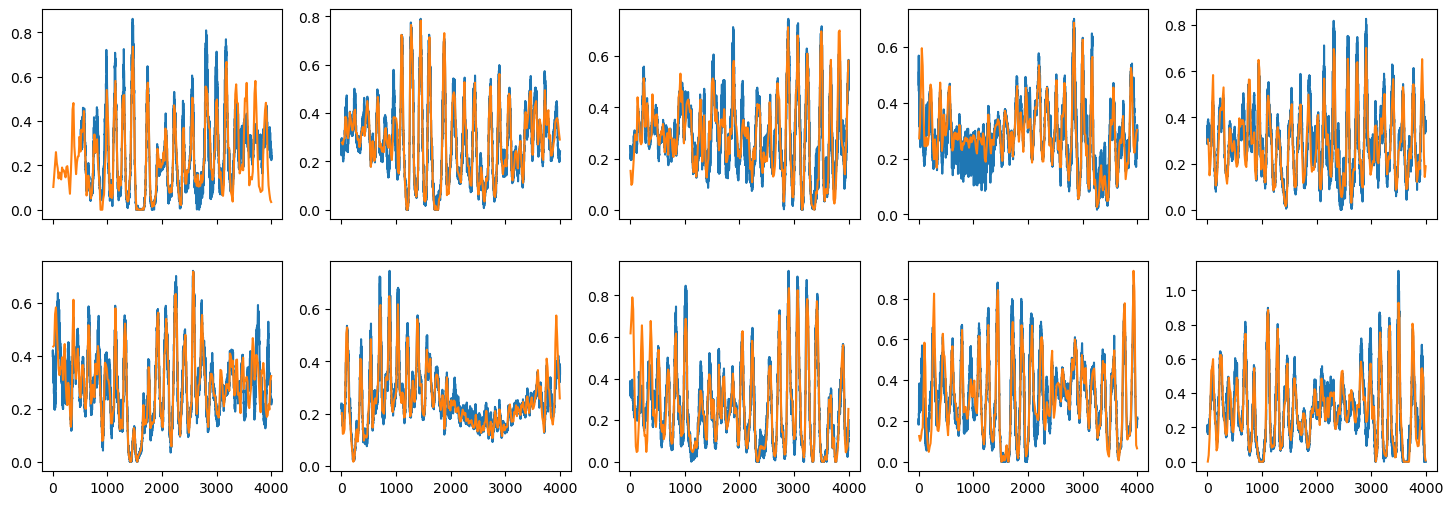

In [47]:
fig, axes = plt.subplots(2, 5, figsize=(18, 6), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.plot(ref[i])
    ax.plot(indices, preds[i])

In [18]:
for i in range(23, 24):
    for annot in ["nuc", "pol", "nucpol"]:
        track = 0
        model_name = f"model_myco_{annot}_pt{i}"
        print(model_name, end="\t")
        if "nuc" in annot:
            print("nuc", end="\t")
            with pbw.open(
                f"Trainedmodels/{model_name}/preds_{model_name}_on_W303_Mmmyco_mid_track{track}.bw"
            ) as bw:
                preds_nuc = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}
            compute_corrs_and_save(
                exp_nuc,
                preds_mid=preds_nuc,
                output_file=f"Trainedmodels/{model_name}/corrs_nuc_bychrom.tsv",
            )
            track += 1
        if "pol" in annot:
            print("pol", end="\t")
            with pbw.open(
                f"Trainedmodels/{model_name}/preds_{model_name}_on_W303_Mmmyco_mid_track{track}.bw"
            ) as bw:
                preds_pol = {k: bw.values(k, 0, -1, numpy=True) for k in bw.chroms()}
            compute_corrs_and_save(
                exp_pol,
                preds_mid=preds_pol,
                output_file=f"Trainedmodels/{model_name}/corrs_pol_bychrom.tsv",
            )
        print()

model_myco_nuc_pt23	nuc	
model_myco_pol_pt23	pol	
model_myco_nucpol_pt23	nuc	pol	


In [24]:
corrs = []
for track in ["nuc", "pol"]:
    if track == "nuc":
        continue
    corrs_track = []
    for model_name, model_label in [
        ("model_myco_nuc_pt5", "base_nuc_2kb"),
        ("model_myco_nuc_pt14", "base_nuc_4kb"),
        ("model_myco_nuc_pt15", "base_nuc_8kb"),
        ("model_myco_nuc_pt16", "base_16kb"),
        ("model_myco_nuc_pt8", "filterx2_nuc_2kb"),
        ("model_myco_nuc_pt17", "filterx2_nuc_4kb"),
        ("model_myco_nuc_pt18", "filterx2_nuc_8kb"),
        ("model_myco_nuc_pt19", "filterx2_nuc_16kb"),
        ("model_myco_nuc_pt23", "filterx2_nuc_16kb_rep2"),
        ("model_myco_nuc_pt9", "bassenji_nuc_2kb"),
        ("model_myco_nuc_pt20", "bassenji_nuc_4kb"),
        ("model_myco_nuc_pt21", "bassenji_nuc_8kb"),
        ("model_myco_nuc_pt22", "bassenji_nuc_16kb"),
        ("model_myco_nucpol_pt4", "base_nucpol_2kb"),
        ("model_myco_nucpol_pt14", "base_nucpol_4kb"),
        ("model_myco_nucpol_pt15", "base_nucpol_8kb"),
        ("model_myco_nucpol_pt16", "base_nucpol_16kb"),
        ("model_myco_nucpol_pt8", "filterx2_nucpol_2kb"),
        ("model_myco_nucpol_pt17", "filterx2_nucpol_4kb"),
        ("model_myco_nucpol_pt18", "filterx2_nucpol_8kb"),
        ("model_myco_nucpol_pt19", "filterx2_nucpol_16kb"),
        ("model_myco_nucpol_pt23", "filterx2_nucpol_16kb_rep2"),
        ("model_myco_nucpol_pt9", "bassenji_nucpol_2kb"),
        ("model_myco_nucpol_pt20", "bassenji_nucpol_4kb"),
        ("model_myco_nucpol_pt21", "bassenji_nucpol_8kb"),
        ("model_myco_nucpol_pt22", "bassenji_nucpol_16kb"),
        ("model_myco_pol_pt1", "base_pol_2kb"),
        ("model_myco_pol_pt14", "base_pol_4kb"),
        ("model_myco_pol_pt15", "base_pol_8kb"),
        ("model_myco_pol_pt16", "base_pol_16kb"),
        ("model_myco_pol_pt8", "filterx2_pol_2kb"),
        ("model_myco_pol_pt17", "filterx2_pol_4kb"),
        ("model_myco_pol_pt18", "filterx2_pol_8kb"),
        ("model_myco_pol_pt19", "filterx2_pol_16kb"),
        ("model_myco_pol_pt23", "filterx2_pol_16kb_rep2"),
        ("model_myco_pol_pt9", "bassenji_pol_2kb"),
        ("model_myco_pol_pt20", "bassenji_pol_4kb"),
        ("model_myco_pol_pt21", "bassenji_pol_8kb"),
        ("model_myco_pol_pt22", "bassenji_pol_16kb"),
    ]:
        try:
            df_corrs = pd.read_csv(
                f"Trainedmodels/{model_name}/corrs_{track}_bychrom.tsv",
                sep="\t",
                index_col=0,
            )
        except FileNotFoundError:
            continue
        corrs_track.append(
            df_corrs.loc["chrXVI":, "merge_mid-exp"]
            .rename(model_label)
            .rename(lambda x: f"{x}_{track}")
        )
    corrs.append(pd.concat(corrs_track, axis=1))
corrs = pd.concat(corrs, axis=0)
corrs

,base_nucpol_2kb,base_nucpol_4kb,base_nucpol_8kb,base_nucpol_16kb,filterx2_nucpol_2kb,filterx2_nucpol_4kb,filterx2_nucpol_8kb,filterx2_nucpol_16kb,filterx2_nucpol_16kb_rep2,bassenji_nucpol_2kb,...,base_pol_16kb,filterx2_pol_2kb,filterx2_pol_4kb,filterx2_pol_8kb,filterx2_pol_16kb,filterx2_pol_16kb_rep2,bassenji_pol_2kb,bassenji_pol_4kb,bassenji_pol_8kb,bassenji_pol_16kb
chrXVI_pol,0.675,0.656,0.659,0.680,0.710,0.724,0.714,0.734,0.686,0.604,...,0.711,0.690,0.689,0.692,0.727,0.699,0.582,0.597,0.598,0.543
Mmmyco_pol,0.193,0.160,0.199,0.139,0.202,0.152,0.038,0.153,0.099,0.014,...,0.127,0.171,0.110,0.186,0.137,0.139,0.177,0.070,0.135,0.078


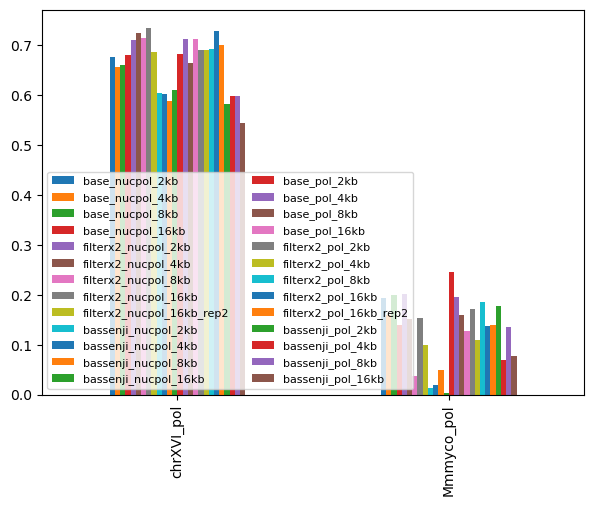

In [25]:
corrs.plot(kind="bar", figsize=(7, 5)).legend(loc="lower left", fontsize=8, ncol=2)

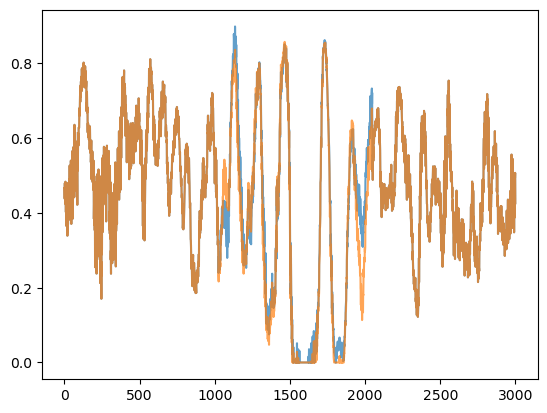

In [34]:
plt.plot(preds_model["chrI_for"][:3000], alpha=0.7)
plt.plot(preds_model_mid["chrI_for"][:3000], alpha=0.7)
plt.plot(exp_nuc["chrI"][:3000])

In [ ]:
res = sliding_correlation(
    preds_model["chrXVI_for"], preds_model["chrXVI_rev"], np.arange(200)
)
resfor = sliding_correlation(
    preds_model["chrXVI_for"], preds_model["chrXVI_for"], np.arange(200)
)
plt.plot(res)
plt.plot(resfor)

In [175]:
importlib.reload(predict_pytorch)

<module 'predict_pytorch' from '/home/alex/SCerevisiae_chromatin_NN_prediction/predict_pytorch.py'>

In [141]:
chr_id = "chrII"
start = 100_000
arr = np.array(
    [
        train_pytorch.idx_to_onehot(genome_idx[chr_id][start + i : start + 2048 + i])
        for i in range(16)
    ]
)
print(arr.shape)
X = torch.Tensor(arr).to(device)
with torch.no_grad():
    pred = model(X)
pred = pred.cpu()
print(pred.shape)
pred = torch.transpose(pred, 0, 1).reshape(-1, pred.shape[-1])

(16, 2048, 4)
torch.Size([16, 112, 1])


In [194]:
chr_id = "chrII"
start = 2048 * 50
seq = genome_idx[chr_id][start : start + 2048 + 15]
print(seq.shape)
res, ind = predict_pytorch.predict(
    model,
    seq,
    2048,
    16,
    head_crop=8,
    n_tracks=1,
    kept_heads_start=24,
    jump_stride=2048 // 2,
)

(2063,)
112 64 1024 1792
16/16


In [195]:
ind

array([ 512,  513,  514, ..., 1533, 1534, 1535])

In [197]:
2048 - 1535

513

In [198]:
len(ind)

1024

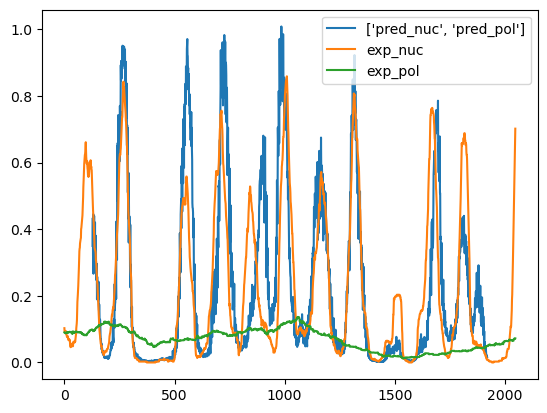

In [138]:
plt.plot(
    np.arange(16 * 8, 16 * 8 + len(pred)),
    pred,
    label=["pred_nuc", "pred_pol"],
)
plt.plot(exp_nuc[chr_id][start : start + 2048], label="exp_nuc")
plt.plot(exp_pol[chr_id][start : start + 2048], label="exp_pol")
plt.legend()
# plt.plot(preds_model_mid_nuc[f"{chr_id}_for"][start : start + 2048], label="pred_nuc")

In [121]:
importlib.reload(train_pytorch)

<module 'train_pytorch' from '/home/alex/SCerevisiae_chromatin_NN_prediction/train_pytorch.py'>

In [122]:
dataset = train_pytorch.SequenceDatasetRAM(
    fasta_file,
    [nuc_file],
    ["chrXIV", "chrXV"],
    2048,
    16,
    strand="both",
    removeNs=True,
    remove0s=True,
)
dataset_crop = train_pytorch.SequenceDatasetRAMCrop(
    fasta_file,
    [nuc_file],
    ["chrXIV", "chrXV"],
    2048,
    16,
    strand="both",
    removeNs=True,
    remove0s=True,
)

In [123]:
len(dataset.positions), len(dataset_crop.positions)

(1847134, 1847044)

In [124]:
X, y, w = dataset[15]
Xc, yc, wc = dataset_crop[0]
for i in range(2000):
    seq = dataset.seq_dict[0][i : i + 2048]
    if np.all(X == train_pytorch.idx_to_onehot(seq)) or np.all(
        train_pytorch.RC_idx(X) == train_pytorch.idx_to_onehot(seq)
    ):
        print(i)
        break
for i in range(2000):
    seq_crop = dataset_crop.seq_dict[0][i : i + 2048]
    if np.all(Xc == train_pytorch.idx_to_onehot(seq_crop)) or np.all(
        train_pytorch.RC_idx(Xc) == train_pytorch.idx_to_onehot(seq_crop)
    ):
        print("crop", i)
        break

In [129]:
np.all(X == Xc), np.all(y == yc), np.all(w == wc)

(True, True, False)

In [132]:
y.nonzero(), yc.nonzero()

((array([0]), array([0])), (array([0]), array([0])))

In [133]:
w.nonzero(), wc.nonzero()

((array([127]), array([0])), (array([0]), array([0])))

In [7]:
import gzip

In [13]:
with gzip.open("test.fa.gz", "rt") as f:
    # for line in f:
    #     print(line)
    handle = SeqIO.parse(f, "fasta")
    seqdic = SeqIO.to_dict(handle)
for k, v in seqdic.items():
    print(k, v)

chr1 ID: chr1
Name: chr1
Description: chr1
Number of features: 0
Seq('ATATATAGCGCCTAGCTAGCTATTAGCTA')
chr2 ID: chr2
Name: chr2
Description: chr2
Number of features: 0
Seq('ATATATATAAAACCGCTCCCGATAAAGCTCGAGCGGGCTCGAGCTAGCTGAGCT...ATC')


In [19]:
fasta_path = "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa"
# fasta_path = "/home/alex/shared_folder/Human/genome/T2T-CHM13v2.0/ncbi-genomes-2022-10-24/GCF_009914755.1_T2T-CHM13v2.0_genomic.fna"
handle = SeqIO.parse(fasta_path, format="fasta")
dicseq = SeqIO.to_dict(handle)
for k, v in dicseq.items():
    print(k, v)

chrI ID: chrI
Name: chrI
Description: chrI
Number of features: 0
Seq('ACACCCACACACCACACCCACACACACACCACACCCACACACCCACACACCACA...GTG')
chrII ID: chrII
Name: chrII
Description: chrII
Number of features: 0
Seq('CCACACCCCCCCACACCCACACCCACACACTCTCTTACATCTACCTCTACTCTC...TGT')
chrIII ID: chrIII
Name: chrIII
Description: chrIII
Number of features: 0
Seq('CACACCCACACACCACACCCACACACACCACACACCCACACACACACCACACCC...GTG')
chrIV ID: chrIV
Name: chrIV
Description: chrIV
Number of features: 0
Seq('ATGCGCTCAGTTAGCTGGAGTCGCGTTGGTTAACAAATTAACTAAATTCACCAT...GTG')
chrV ID: chrV
Name: chrV
Description: chrV
Number of features: 0
Seq('CCCACACACCACACCCACACTTTTCACATCTATCTTTACTCTCGCTGTCACTCC...GTG')
chrVI ID: chrVI
Name: chrVI
Description: chrVI
Number of features: 0
Seq('CACACCCACACACCACACCCACACACCACACCACACACCACACCACACACCACA...GTG')
chrVII ID: chrVII
Name: chrVII
Description: chrVII
Number of features: 0
Seq('CACCACACCCACACCACACCCACACCACACCCACACCACACCACACCACACCCA...GTG')
chrVIII ID: chrVIII
Name: chrVIII
Descrip

In [20]:
str(v.seq)

'CCACACACCCACACCACCCACACCCACACCCACACCACACCCACACCACACCCACACACCACACCCCCACACACCCACACCACCCACACCCACACCCACACCACACCCACACCACACCCACACACCACACCCACACCACACCACACCCACACCACACCCACACCCCACACCCACACACACCACACCCACACCACACCCACACCACACCCACACCACcgttgcgaggtactaaaggcCAGTGGCTGCTGCCAGTGGCGATAAGTCGTGTCTTACCGGGTTGGACTCAAGACGATAGTTACCGGATAAGGCGCAGCGGTCGGGCTGAACGGGGGGTTCGTGCACACAGCCCAGCTTGGAGCGAACGACCTACACCGAACTGAGATACCTACAGCGTGAGCTATGAGAAAGCGCCACGCTTCCCGAAGGGAGAAAGGCGGACAGGTATCCGGTAAGCGGCAGGGTCGGAACAGGAGAGCGCACGAGGGAGCTTCCAGGGGGAAACGCCTGGTATCTTTATAGTCCTGTCGGGTTTCGCCACCTCTGACTTGAGCGTCGATTTTTGTGATGCTCGTCAGGGGGGCGGAGCCTATGGAAAAACGCCAGCAACGCGGCCTTTTTACGGTTCCTGGCCTTTTGCTGGCCTTTTGCTCACATGTTCTTTCCTGCGTTATCCCCTGATTCTGTGGATAACCGTATTACCGCCTTTGAGTGAGCTGATACCGCTCGCCGCAGCCGAACGACCGAGCGCAGCGAGTCAGTGAGCGAGGAAGCGGAAGAGCGCCCAATACGCAAACCGCCTCTCCCCGCGCGTTGGCCGATTCATTAATGCACGCTAGCATTTAAATGGTACCCTTTTACACAATTATACGGACTTTATCTTCTTTTTCTAGCAATTCAACTGGGCTACTTTCTTTTTTTATAAAGTCAGTTGCATGATAAATAGCAGTAACAGCATTACTAATTTTGCTTTTATTTTCTTGTGCTTCAAATGTAAAAGTT

In [6]:
np.random.choice(100, 10, replace=False).astype(int)

array([23, 35, 30, 39, 49, 55, 32, 52, 25, 85])

In [ ]:
def pearsonr(pred, target, weights=None):
    """ """
    dim = -1

    centered_x = pred - pred.mean(dim=dim)
    centered_y = target - target.mean(dim=dim)
    #
    covariance = (centered_x * centered_y).sum(dim=dim)
    bessel_corrected_covariance = covariance / (pred.shape[dim] - 1)
    #
    x_std = pred.std(dim=dim)
    y_std = target.std(dim=dim)
    #
    corr = bessel_corrected_covariance / (
        (x_std * y_std) + torch.finfo(torch.float32).eps
    )
    #
    return corr


def mae(output, target):
    return torch.mean(torch.abs(output - target))


def mse(output, target):
    return torch.mean(torch.square(output - target))


def mae_cor(output, target):
    return mae(output, target) + 1 - pearsonr(output, target)

In [ ]:
from typing import Any

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv1d(4, 32, 5)
        self.conv2 = nn.Conv1d(32, 32, 9)
        self.conv3 = nn.Conv1d(32, 32, 11)

        self.maxpool = nn.MaxPool1d(2)
        self.dense1 = nn.Linear(32 * 242, 10)
        self.output = nn.Linear(10, 5)

        self.flat = torch.flatten

    def forward(self, X):
        x = self.conv1(X)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.flat(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.sigmoid(x)

        return x